In [1]:
import pandas as pd

df = pd.read_csv('train.csv', parse_dates=['date'])

# Ordina per chiave temporale e identificativa della serie
df = df.sort_values(by=['store_nbr', 'family', 'date'])

In [2]:
# Esempio di lag di 1, 7, 14, 28 giorni
for lag in [1, 7, 14, 28]:
    df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)

In [3]:
# Esempio: media su 7 e 14 giorni
for window in [7, 14]:
    df[f'sales_rollmean_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(window=window).mean()

In [4]:
# Rolling std, min, max su 14 giorni
for func in ['std', 'min', 'max']:
    df[f'sales_roll{func}_14'] = (
        df.groupby(['store_nbr', 'family'])['sales']
        .shift(1)
        .rolling(window=14)
        .agg(func)
    )

In [5]:
df['promo_7d'] = (
    df.groupby(['store_nbr', 'family'])['onpromotion']
    .shift(1)
    .rolling(7).sum()
)

In [6]:
# Dopo aver costruito le feature, puoi decidere se droppare o imputare i NaN
df = df.dropna()

In [7]:
# Assumendo che la colonna 'date' sia già in formato datetime
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'] >= 5

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encoding per family e type (stringhe)
le = LabelEncoder()
df['family'] = le.fit_transform(df['family'])
label_encoders = {'family': le}

# store_nbr è già numerico, ma se vuoi assicurarti che sia trattato come categoria:
df['store_nbr'] = df['store_nbr'].astype(int)

In [9]:
# is_holiday: booleano (già True/False), possiamo trasformarlo in 0/1
df['is_holiday'] = df['is_holiday'].astype(int)

# onpromotion è già 0/1

# Riempi eventuali NaN nel prezzo del petrolio con interpolazione o mediana
df['dcoilwtico'] = df['dcoilwtico'].interpolate(method='linear')
df['dcoilwtico'] = df['dcoilwtico'].bfill()  # fallback

In [10]:
# Split on percentage
train_size = 0.8

train = df.sample(frac=train_size, random_state=42)
test = df.drop(train.index)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [11]:
target_col = 'sales'

# Colonne da escludere
drop_cols = ['id', 'date', 'sales']

# Feature matrix
X_train = train.drop(columns=drop_cols)
X_test = test.drop(columns=drop_cols)

# Target
y_train = train[target_col]
y_test = test[target_col]

In [12]:
from xgboost import XGBRegressor

# Istanzia il modello
model = XGBRegressor(
    n_estimators=416,
    max_depth=12,
    learning_rate=0.061262821041241845,
    subsample=0.9173305659044061,
    colsample_bytree=0.5620303828499797,
    min_child_weight=1,
    gamma=2.0104361823750687,
    tree_method='hist',  # più veloce
    random_state=42,
    n_jobs=-1
)

# Fit
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5620303828499797, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=2.0104361823750687, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.061262821041241845,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=416, n_jobs=-1,
             num_parallel_tree=None, ...)

In [20]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)  # Assicurati che le predizioni siano >= 0

msle = mean_squared_log_error(y_test, y_pred)
rmsle = np.sqrt(msle)
print(f"RMSLE: {rmsle:.4f}")

RMSLE: 0.5185


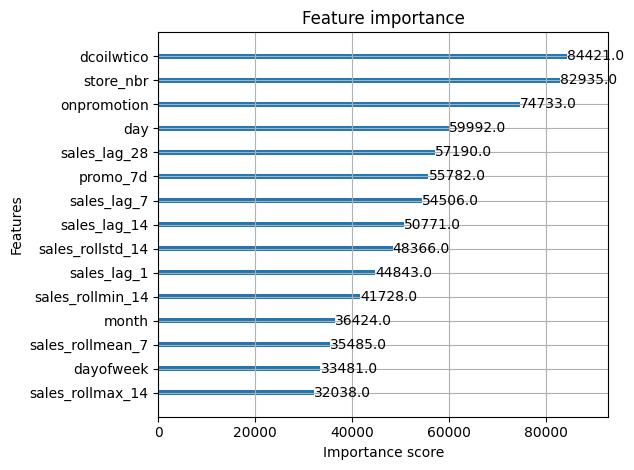

In [21]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model, max_num_features=15)
plt.tight_layout()
plt.show()

In [23]:
print(f"Media vendite: {y_test.mean():.2f}")
print(f"RMSLE: {rmsle:.2f}")
print(f"RMSLE %: {rmsle / y_test.mean() * 100:.2f}%")

Media vendite: 360.03
RMSLE: 0.52
RMSLE %: 0.14%


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test.clip(lower=1))) * 100  # evita div/0
print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}%")

MAE: 40.05, MAPE: 92.24%


In [25]:
test['y_pred'] = y_pred
test['abs_error'] = abs(test['sales'] - test['y_pred'])
test.groupby('family')['abs_error'].mean().sort_values(ascending=False).head(10)

family
12    359.996884
3     254.449560
30    119.942163
7     115.622550
8      64.358133
24     49.440948
5      47.858421
28     45.019887
25     39.582784
11     35.412418
Name: abs_error, dtype: float64